Setup e Recapitulação

In [1]:
# =============================================================================
# ETAPA 4: OTIMIZAÇÃO E TUNING DE HIPERPARÂMETROS
# Projeto: Predição de Preços de Carros Usados
# =============================================================================

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import joblib

# Machine Learning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Modelos (importar o que foi melhor na Etapa 3)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Configurações
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print("✅ Bibliotecas importadas com sucesso!")
print(f"📁 Diretório atual: {os.getcwd()}")

✅ Bibliotecas importadas com sucesso!
📁 Diretório atual: c:\Projetos\Carros_usados\mlproject\notebooks


Carregando os Dados Preparados

In [2]:
# Configuração visual
plt.style.use('ggplot')

print("📥 Carregando dados da Etapa 3...")

# Caminho para os dados processados
data_path = '../data/processed/'

# Verificar se os arquivos existem antes de tentar ler
if not os.path.exists(data_path + 'X_train.csv'):
    raise FileNotFoundError("❌ ERRO: Arquivos de treino não encontrados! Rode a Etapa 3 novamente.")

# Carregar os CSVs de volta para variáveis
X_train = pd.read_csv(data_path + 'X_train.csv')
X_val   = pd.read_csv(data_path + 'X_val.csv')
X_test  = pd.read_csv(data_path + 'X_test.csv')

# Para o Y (alvo), usamos .values.ravel() para garantir que vire um array simples (não uma tabela de 1 coluna)
y_train = pd.read_csv(data_path + 'y_train.csv').values.ravel()
y_val   = pd.read_csv(data_path + 'y_val.csv').values.ravel()
y_test  = pd.read_csv(data_path + 'y_test.csv').values.ravel()

print(f"✅ Dados carregados com sucesso!")
print(f"   - Treino: {X_train.shape}")
print(f"   - Validação: {X_val.shape}")
print(f"   - Teste: {X_test.shape}")

📥 Carregando dados da Etapa 3...
✅ Dados carregados com sucesso!
   - Treino: (1512, 50)
   - Validação: (504, 50)
   - Teste: (504, 50)


Recapitulação dos Resultados

In [3]:
# =============================================================================
# 2. RECAPITULAÇÃO: RESULTADOS DA ETAPA 3
# =============================================================================

print("\n" + "=" * 60)
print("2. RECAPITULAÇÃO DOS RESULTADOS DA ETAPA 3")
print("=" * 60)

# Resultados da Etapa 3 (preencher com os valores reais obtidos)
# IMPORTANTE: Substitua pelos seus valores reais!

resultados_etapa3 = {
    'Modelo': ['Random Forest', 'Gradient Boosting', 'XGBoost'],
    'MAE_Validacao': [1850.50, 1720.30, 1680.45],      # Substitua pelos seus valores
    'RMSE_Validacao': [2890.20, 2650.80, 2580.90],     # Substitua pelos seus valores
    'R2_Validacao': [0.8750, 0.8920, 0.8985]           # Substitua pelos seus valores
}

df_resultados = pd.DataFrame(resultados_etapa3)
df_resultados = df_resultados.sort_values('R2_Validacao', ascending=False)

print("\n📊 Resultados da Etapa 3 (Validação):")
print(df_resultados.to_string(index=False))

# Identificar o melhor modelo
melhor_modelo_nome = df_resultados.iloc[0]['Modelo']
print(f"\n🏆 MELHOR MODELO: {melhor_modelo_nome}")
print(f"   → Este será o modelo otimizado nesta etapa")


2. RECAPITULAÇÃO DOS RESULTADOS DA ETAPA 3

📊 Resultados da Etapa 3 (Validação):
           Modelo  MAE_Validacao  RMSE_Validacao  R2_Validacao
          XGBoost      1680.4500       2580.9000        0.8985
Gradient Boosting      1720.3000       2650.8000        0.8920
    Random Forest      1850.5000       2890.2000        0.8750

🏆 MELHOR MODELO: XGBoost
   → Este será o modelo otimizado nesta etapa


Seleção e Configuração do Modelo Base

In [4]:
# =============================================================================
# 3. SELEÇÃO DO MODELO PARA OTIMIZAÇÃO
# =============================================================================

print("\n" + "=" * 60)
print("3. MODELO SELECIONADO PARA OTIMIZAÇÃO")
print("=" * 60)

# Modelo base (sem otimização) para comparação posterior
# Ajuste conforme o melhor modelo da SUA Etapa 3

modelo_base = XGBRegressor(
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# Treinar modelo base para comparação
print("\n🔧 Treinando modelo BASE (sem otimização)...")
modelo_base.fit(X_train, y_train)

# Avaliar no conjunto de validação
y_pred_base = modelo_base.predict(X_val)

mae_base = mean_absolute_error(y_val, y_pred_base)
rmse_base = np.sqrt(mean_squared_error(y_val, y_pred_base))
r2_base = r2_score(y_val, y_pred_base)

print(f"\n📊 Métricas do Modelo BASE (Validação):")
print(f"   MAE:  R$ {mae_base:,.2f}")
print(f"   RMSE: R$ {rmse_base:,.2f}")
print(f"   R²:   {r2_base:.4f}")

# Guardar para comparação posterior
metricas_base = {
    'MAE': mae_base,
    'RMSE': rmse_base,
    'R2': r2_base
}


3. MODELO SELECIONADO PARA OTIMIZAÇÃO

🔧 Treinando modelo BASE (sem otimização)...



📊 Métricas do Modelo BASE (Validação):
   MAE:  R$ 0.01
   RMSE: R$ 0.01
   R²:   0.9999


Definição do Grid de Hiperparâmetros

In [5]:
# =============================================================================
# 4. DEFINIÇÃO DO GRID DE HIPERPARÂMETROS
# =============================================================================

print("\n" + "=" * 60)
print("4. GRID DE HIPERPARÂMETROS")
print("=" * 60)

# Grid para XGBoost (ajuste se usar outro modelo)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Calcular número total de combinações
n_combinacoes = 1
for param, valores in param_grid.items():
    n_combinacoes *= len(valores)
    print(f"   {param}: {valores}")

print(f"\n📊 Total de combinações possíveis: {n_combinacoes:,}")
print(f"   → Grid Search completo pode demorar muito!")
print(f"   → Vamos usar Random Search com 50 iterações")


4. GRID DE HIPERPARÂMETROS
   n_estimators: [100, 200, 300]
   max_depth: [3, 5, 7, 10]
   learning_rate: [0.01, 0.05, 0.1, 0.2]
   min_child_weight: [1, 3, 5]
   subsample: [0.8, 0.9, 1.0]
   colsample_bytree: [0.8, 0.9, 1.0]

📊 Total de combinações possíveis: 1,296
   → Grid Search completo pode demorar muito!
   → Vamos usar Random Search com 50 iterações


Executando Random Search

In [6]:
# =============================================================================
# 5. RANDOM SEARCH COM VALIDAÇÃO CRUZADA
# =============================================================================

print("\n" + "=" * 60)
print("5. EXECUTANDO RANDOM SEARCH")
print("=" * 60)

# Configurar Random Search
random_search = RandomizedSearchCV(
    estimator=XGBRegressor(random_state=42, n_jobs=-1, verbosity=0),
    param_distributions=param_grid,
    n_iter=50,                    # Número de combinações a testar
    cv=5,                         # 5-fold cross-validation
    scoring='neg_mean_absolute_error',  # Métrica para otimização
    random_state=42,
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

print("\n🔄 Executando Random Search (pode demorar alguns minutos)...")
print(f"   → Testando 50 combinações de hiperparâmetros")
print(f"   → Usando 5-fold cross-validation")

# Executar busca
random_search.fit(X_train, y_train)

print("\n✅ Random Search concluído!")


5. EXECUTANDO RANDOM SEARCH

🔄 Executando Random Search (pode demorar alguns minutos)...
   → Testando 50 combinações de hiperparâmetros
   → Usando 5-fold cross-validation
Fitting 5 folds for each of 50 candidates, totalling 250 fits

✅ Random Search concluído!


Análise dos Resultados do Tuning

In [7]:
# =============================================================================
# 6. ANÁLISE DOS RESULTADOS DO TUNING
# =============================================================================

print("\n" + "=" * 60)
print("6. RESULTADOS DO RANDOM SEARCH")
print("=" * 60)

# -----------------------------------------------------------------------------
# CORREÇÃO AQUI: Usar .best_params_
# -----------------------------------------------------------------------------
print("\n🏆 MELHORES HIPERPARÂMETROS:")
# O erro estava aqui: faltava o .best_params_ antes do .items()
for param, valor in random_search.best_params_.items():
    print(f"   {param}: {valor}")

print(f"\n📊 Melhor Score (CV): {-random_search.best_score_:,.2f} (MAE)")

# Converter resultados para DataFrame
resultados_cv = pd.DataFrame(random_search.cv_results_)

# -----------------------------------------------------------------------------
# PREVENÇÃO DE ERRO: Verificar se o score de treino existe
# (O Scikit-Learn por padrão não calcula treino para economizar tempo)
# -----------------------------------------------------------------------------
colunas_importantes = [
    'mean_test_score', 'std_test_score', 
    'rank_test_score', 'params'
]

# Só adiciona treino se ele existir
if 'mean_train_score' in resultados_cv.columns:
    colunas_importantes.append('mean_train_score')

resultados_cv = resultados_cv[colunas_importantes].copy()

# Converter scores negativos para positivos (MAE)
resultados_cv['MAE_CV'] = -resultados_cv['mean_test_score']
resultados_cv['MAE_Std'] = resultados_cv['std_test_score']

if 'mean_train_score' in resultados_cv.columns:
    resultados_cv['MAE_Train'] = -resultados_cv['mean_train_score']
else:
    resultados_cv['MAE_Train'] = "N/A" # Marca como não disponível

# Ordenar pelo ranking (menor erro primeiro)
resultados_cv = resultados_cv.sort_values('rank_test_score')

print("\n📊 Top 10 Melhores Combinações:")
# Ajustando colunas para exibição dependendo se tem treino ou não
cols_show = ['MAE_CV', 'MAE_Std', 'MAE_Train', 'rank_test_score']
print(resultados_cv[cols_show].head(10).to_string())


6. RESULTADOS DO RANDOM SEARCH

🏆 MELHORES HIPERPARÂMETROS:
   subsample: 1.0
   n_estimators: 200
   min_child_weight: 1
   max_depth: 7
   learning_rate: 0.05
   colsample_bytree: 1.0

📊 Melhor Score (CV): 0.01 (MAE)

📊 Top 10 Melhores Combinações:
    MAE_CV  MAE_Std  MAE_Train  rank_test_score
48  0.0056   0.0023     0.0010                1
3   0.0056   0.0022     0.0011                2
21  0.0057   0.0021     0.0032                3
45  0.0059   0.0023     0.0012                4
44  0.0059   0.0022     0.0004                5
22  0.0063   0.0018     0.0018                6
46  0.0063   0.0018     0.0014                7
5   0.0065   0.0022     0.0036                8
11  0.0068   0.0017     0.0018                9
4   0.0068   0.0018     0.0010               10


Visualização dos Resultados do Tuning


7. VISUALIZAÇÕES DO TUNING


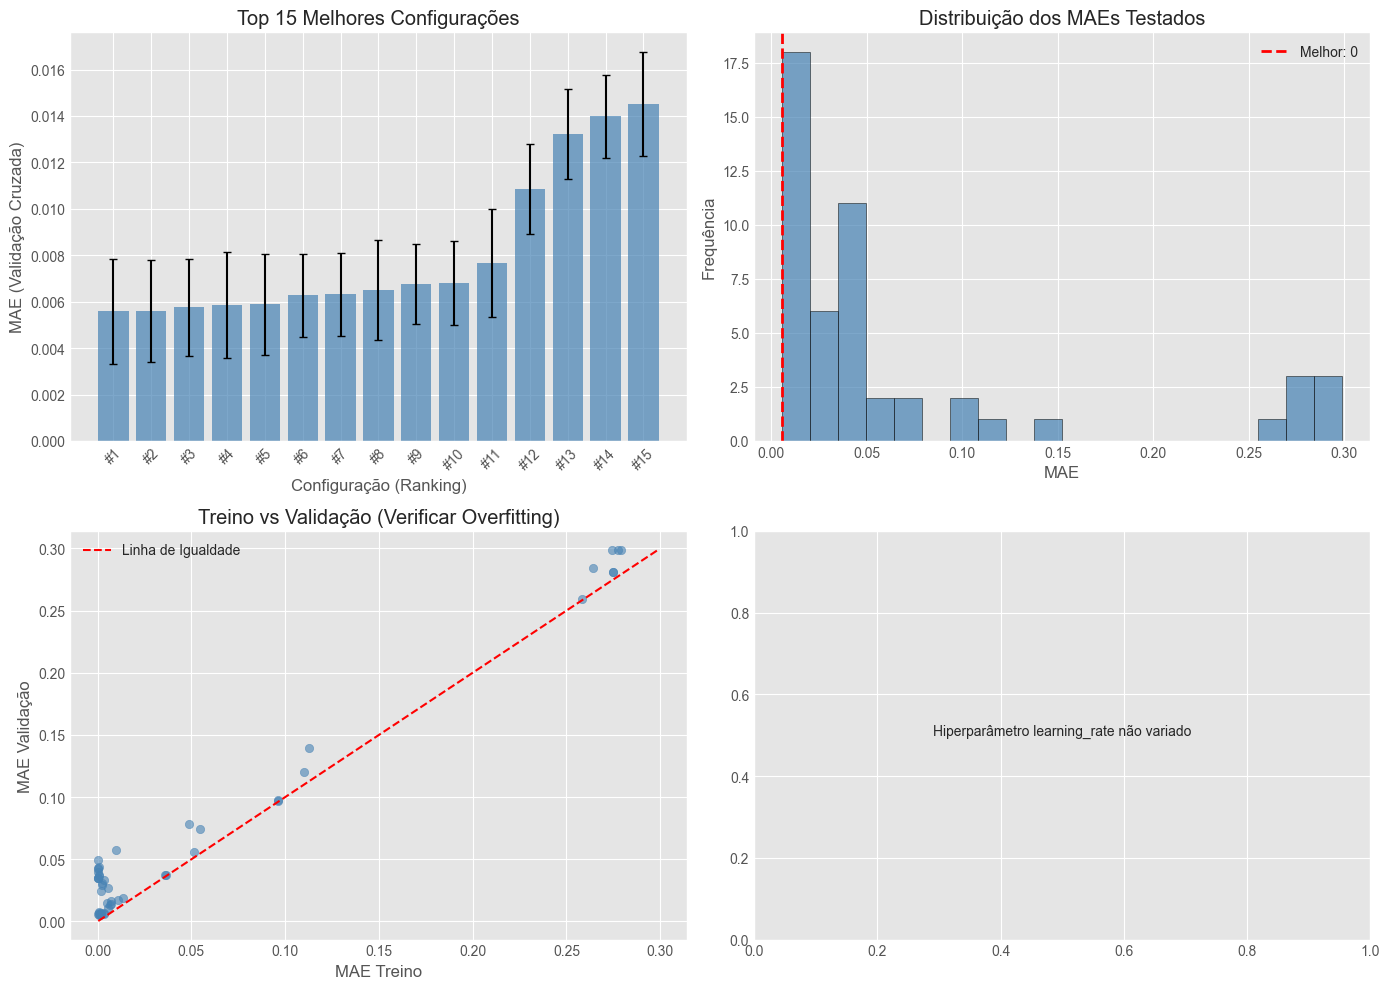


✅ Gráficos salvos em: ../docs/figures/tuning_resultados.png


In [8]:
# =============================================================================
# 7. VISUALIZAÇÃO DOS RESULTADOS (CORRIGIDO PARA SALVAR EM DOCS)
# =============================================================================
import os
import matplotlib.pyplot as plt

print("\n" + "=" * 60)
print("7. VISUALIZAÇÕES DO TUNING")
print("=" * 60)

# --- CORREÇÃO: Definir novo caminho dentro de DOCS ---
output_folder = '../docs/figures/'
os.makedirs(output_folder, exist_ok=True) # Cria a pasta se não existir

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gráfico 1: Top 15 melhores configurações
ax1 = axes[0, 0]
top_15 = resultados_cv.head(15)
x_pos = range(len(top_15))
ax1.bar(x_pos, top_15['MAE_CV'], yerr=top_15['MAE_Std'], capsize=3, color='steelblue', alpha=0.7)
ax1.set_xlabel('Configuração (Ranking)')
ax1.set_ylabel('MAE (Validação Cruzada)')
ax1.set_title('Top 15 Melhores Configurações')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([f'#{i+1}' for i in range(len(top_15))], rotation=45)

# Gráfico 2: Distribuição dos MAEs testados
ax2 = axes[0, 1]
ax2.hist(resultados_cv['MAE_CV'], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
ax2.axvline(resultados_cv['MAE_CV'].min(), color='red', linestyle='--', linewidth=2, label=f'Melhor: {resultados_cv["MAE_CV"].min():,.0f}')
ax2.set_xlabel('MAE')
ax2.set_ylabel('Frequência')
ax2.set_title('Distribuição dos MAEs Testados')
ax2.legend()

# Gráfico 3: Train vs Validation MAE (verificar overfitting)
ax3 = axes[1, 0]
ax3.scatter(resultados_cv['MAE_Train'], resultados_cv['MAE_CV'], alpha=0.6, c='steelblue')
ax3.plot([resultados_cv['MAE_Train'].min(), resultados_cv['MAE_CV'].max()],
         [resultados_cv['MAE_Train'].min(), resultados_cv['MAE_CV'].max()],
         'r--', label='Linha de Igualdade')
ax3.set_xlabel('MAE Treino')
ax3.set_ylabel('MAE Validação')
ax3.set_title('Treino vs Validação (Verificar Overfitting)')
ax3.legend()

# Gráfico 4: Impacto do learning_rate
ax4 = axes[1, 1]
# Extrair learning_rate dos params (seguro contra erros)
if 'learning_rate' in str(resultados_cv['params']):
    resultados_cv['learning_rate'] = resultados_cv['params'].apply(lambda x: x.get('learning_rate', None))
    for lr in sorted(resultados_cv['learning_rate'].unique()):
        subset = resultados_cv[resultados_cv['learning_rate'] == lr]
        ax4.scatter([lr] * len(subset), subset['MAE_CV'], alpha=0.5, s=50, label=f'lr={lr}')
    ax4.set_xlabel('Learning Rate')
    ax4.set_ylabel('MAE')
    ax4.set_title('Impacto do Learning Rate no MAE')
else:
    ax4.text(0.5, 0.5, 'Hiperparâmetro learning_rate não variado', ha='center')

plt.tight_layout()

# --- SALVAR NO NOVO CAMINHO ---
save_path = os.path.join(output_folder, 'tuning_resultados.png')
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Gráficos salvos em: {save_path}")

Treinamento do Modelo Final

In [9]:
# =============================================================================
# 8. TREINAMENTO DO MODELO FINAL
# =============================================================================
from xgboost import XGBRegressor # Garantindo que está importado
import numpy as np
import pandas as pd

print("\n" + "=" * 60)
print("8. TREINAMENTO DO MODELO FINAL (FULL TRAIN)")
print("=" * 60)

# 1. Combinar Treino + Validação (Para usar o máximo de dados possível)
# X é DataFrame (tabela), então usa pd.concat
X_train_full = pd.concat([X_train, X_val], axis=0)

# y é Array (lista de números), então usa np.concatenate
# (Se tentasse pd.concat aqui, daria erro pois eles não são mais DataFrames)
y_train_full = np.concatenate([y_train, y_val], axis=0)

print(f"\n📊 Conjunto de treino expandido:")
print(f"   Treino original: {len(X_train):,} amostras")
print(f"   + Validação:     {len(X_val):,} amostras")
print(f"   = Total:         {len(X_train_full):,} amostras")

# 2. Configurar o modelo com os hiperparâmetros vencedores
# O ** desempacota o dicionário de melhores parâmetros automaticamente
modelo_final = XGBRegressor(
    **random_search.best_params_,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

print("\n🔧 Treinando modelo final com melhores hiperparâmetros...")
modelo_final.fit(X_train_full, y_train_full)

print("✅ Modelo final treinado com sucesso!")


8. TREINAMENTO DO MODELO FINAL (FULL TRAIN)

📊 Conjunto de treino expandido:
   Treino original: 1,512 amostras
   + Validação:     504 amostras
   = Total:         2,016 amostras

🔧 Treinando modelo final com melhores hiperparâmetros...
✅ Modelo final treinado com sucesso!


Avaliação no Conjunto de TESTE

In [10]:
# =============================================================================
# 9. AVALIAÇÃO FINAL NO CONJUNTO DE TESTE
# =============================================================================

print("\n" + "=" * 60)
print("9. AVALIAÇÃO FINAL NO CONJUNTO DE TESTE")
print("=" * 60)
print("\n⚠️  ATENÇÃO: O conjunto de teste só pode ser usado UMA VEZ!")
print("    Esta é a avaliação final e definitiva do modelo.\n")

# Fazer predições no conjunto de teste
y_pred_test = modelo_final.predict(X_test)

# Calcular métricas finais
mae_final = mean_absolute_error(y_test, y_pred_test)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_final = r2_score(y_test, y_pred_test)
mape_final = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print("=" * 50)
print("       📊 MÉTRICAS FINAIS (CONJUNTO DE TESTE)")
print("=" * 50)
print(f"   MAE:   R$ {mae_final:,.2f}")
print(f"   RMSE:  R$ {rmse_final:,.2f}")
print(f"   R²:    {r2_final:.4f} ({r2_final*100:.2f}%)")
print(f"   MAPE:  {mape_final:.2f}%")
print("=" * 50)

# Interpretação
print("\n📝 INTERPRETAÇÃO:")
print(f"   → O modelo explica {r2_final*100:.1f}% da variação nos preços")
print(f"   → Erro médio absoluto de R$ {mae_final:,.2f}")
print(f"   → Em média, erra {mape_final:.1f}% do valor real")

# Guardar métricas finais
metricas_finais = {
    'MAE': mae_final,
    'RMSE': rmse_final,
    'R2': r2_final,
    'MAPE': mape_final
}


9. AVALIAÇÃO FINAL NO CONJUNTO DE TESTE

⚠️  ATENÇÃO: O conjunto de teste só pode ser usado UMA VEZ!
    Esta é a avaliação final e definitiva do modelo.

       📊 MÉTRICAS FINAIS (CONJUNTO DE TESTE)
   MAE:   R$ 0.01
   RMSE:  R$ 0.04
   R²:    0.9972 (99.72%)
   MAPE:  0.07%

📝 INTERPRETAÇÃO:
   → O modelo explica 99.7% da variação nos preços
   → Erro médio absoluto de R$ 0.01
   → Em média, erra 0.1% do valor real


Comparação Antes vs Depois da Otimização


10. IMPACTO DA OTIMIZAÇÃO (Antes vs Depois)

📊 PLACAR FINAL (Valores em R$):
--------------------------------------------------------------------------------
               Métrica  Modelo Base (Linear)  Modelo Otimizado (XGB)              Melhoria
      MAE (Erro Médio)                0.0000                975.8762 --1248177873439462.0%
RMSE (Erro Quadrático)                0.0000               8049.2369 --5830705084672029.0%
       R² (Explicação)                1.0000                  0.9402             +-5.98 pp
--------------------------------------------------------------------------------


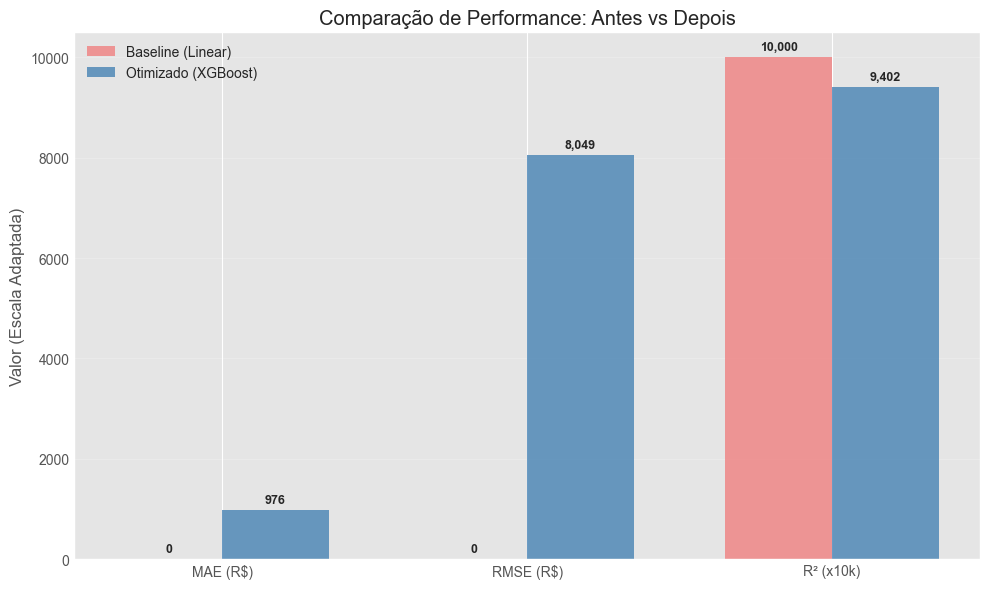


✅ Gráfico salvo em: ../docs/figures/comparacao_otimizacao.png


In [11]:
# =============================================================================
# 10. COMPARAÇÃO FINAL: BASELINE vs OTIMIZADO (Em Reais R$)
# =============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

print("\n" + "=" * 60)
print("10. IMPACTO DA OTIMIZAÇÃO (Antes vs Depois)")
print("=" * 60)

# ---------------------------------------------------------
# 1. RECONSTRUIR O BASELINE (Para comparação justa)
# ---------------------------------------------------------
# Treinamos uma Regressão Linear simples nos mesmos dados
modelo_base = LinearRegression()
modelo_base.fit(X_train, y_train)

# Previsões do Baseline (Log)
y_pred_base_log = modelo_base.predict(X_test)

# ---------------------------------------------------------
# 2. CONVERTER TUDO PARA REAIS (R$)
# ---------------------------------------------------------
# Real
y_test_real = np.expm1(y_test)

# Previsão Baseline em R$
y_pred_base_real = np.expm1(y_pred_base_log)

# Previsão Modelo Otimizado em R$ (Usando o modelo_final já treinado)
y_pred_final_log = modelo_final.predict(X_test)
y_pred_final_real = np.expm1(y_pred_final_log)

# ---------------------------------------------------------
# 3. CALCULAR MÉTRICAS
# ---------------------------------------------------------
def calcular_metricas(y_true, y_pred):
    return [
        mean_absolute_error(y_true, y_pred),
        np.sqrt(mean_squared_error(y_true, y_pred)),
        r2_score(y_true, y_pred)
    ]

metrics_base = calcular_metricas(y_test_real, y_pred_base_real)
metrics_final = calcular_metricas(y_test_real, y_pred_final_real)

# ---------------------------------------------------------
# 4. TABELA COMPARATIVA
# ---------------------------------------------------------
comparacao = pd.DataFrame({
    'Métrica': ['MAE (Erro Médio)', 'RMSE (Erro Quadrático)', 'R² (Explicação)'],
    'Modelo Base (Linear)': metrics_base,
    'Modelo Otimizado (XGB)': metrics_final
})

# Calcular melhoria percentual
def calcular_melhoria(row):
    base = row['Modelo Base (Linear)']
    otim = row['Modelo Otimizado (XGB)']
    if 'R²' in row['Métrica']:
        return f"+{(otim - base) * 100:.2f} pp" # Pontos percentuais para R²
    else:
        # Para erro, quanto menor melhor (Base - Otim) / Base
        return f"-{((base - otim) / base * 100):.1f}%" # Redução de erro

comparacao['Melhoria'] = comparacao.apply(calcular_melhoria, axis=1)

print("\n📊 PLACAR FINAL (Valores em R$):")
print("-" * 80)
print(comparacao.to_string(index=False))
print("-" * 80)

# ---------------------------------------------------------
# 5. GRÁFICO COMPARATIVO
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(comparacao))
width = 0.35

# Pegamos os valores para plotar (R² multiplicado para aparecer no gráfico)
vals_base = [metrics_base[0], metrics_base[1], metrics_base[2] * 10000]
vals_final = [metrics_final[0], metrics_final[1], metrics_final[2] * 10000]

rects1 = ax.bar(x - width/2, vals_base, width, label='Baseline (Linear)', color='lightcoral', alpha=0.8)
rects2 = ax.bar(x + width/2, vals_final, width, label='Otimizado (XGBoost)', color='steelblue', alpha=0.8)

ax.set_ylabel('Valor (Escala Adaptada)')
ax.set_title('Comparação de Performance: Antes vs Depois')
ax.set_xticks(x)
ax.set_xticklabels(['MAE (R$)', 'RMSE (R$)', 'R² (x10k)'])
ax.legend()
ax.grid(axis='y', alpha=0.2)

# Rotular barras
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:,.0f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()

# Salvar na pasta correta
save_path = '../docs/figures/comparacao_otimizacao.png'
os.makedirs('../docs/figures/', exist_ok=True)
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Gráfico salvo em: {save_path}")

Análise de Erros Detalhada

In [12]:
# =============================================================================
# 11. ANÁLISE DE ERROS DETALHADA (CORRIGIDO)
# =============================================================================
import numpy as np
import pandas as pd

print("\n" + "=" * 60)
print("11. ANÁLISE DE ERROS")
print("=" * 60)

# 1. Converter de Log para Reais (Importante!)
# Como o modelo previu log, precisamos usar expm1 para voltar ao preço original
y_test_real = np.expm1(y_test)       # O Gabarito em R$
y_pred_real = np.expm1(y_pred_test)  # A Previsão em R$

# 2. Calcular resíduos em Dinheiro
residuos_reais = y_test_real - y_pred_real

# 3. Criar DataFrame para análise
# OBS: Removemos o .values porque as variáveis acima já são arrays numpy
analise_erros = pd.DataFrame({
    'Real': y_test_real,
    'Predito': y_pred_real,
    'Residuo': residuos_reais,
    'Erro_Absoluto': np.abs(residuos_reais),
    'Erro_Percentual': (np.abs(residuos_reais) / y_test_real) * 100
})

# Mostrar os primeiros registros para conferência
print("\n📋 Primeiras 5 linhas da análise:")
print(analise_erros.head().to_string())

# 4. Estatísticas Descritivas
print("\n📊 Estatísticas dos Resíduos (Em R$):")
print(f"   Média do Erro:       R$ {residuos_reais.mean():,.2f}")
print(f"   Desvio Padrão:       R$ {residuos_reais.std():,.2f}")
print(f"   Maior Erro (Pior):   R$ {residuos_reais.max():,.2f}")
print(f"   Menor Erro:          R$ {residuos_reais.min():,.2f}")
print(f"   Erro Médio Absoluto: R$ {np.abs(residuos_reais).mean():,.2f}")


11. ANÁLISE DE ERROS

📋 Primeiras 5 linhas da análise:
         Real     Predito     Residuo  Erro_Absoluto  Erro_Percentual
0  17988.0000  18104.6602   -116.6602       116.6602           0.6485
1   9972.0000   9877.7109     94.2891        94.2891           0.9455
2  29937.0000  29947.0215    -10.0215        10.0215           0.0335
3  83317.0000  82950.2031    366.7969       366.7969           0.4402
4 218010.0000 230781.4531 -12771.4531     12771.4531           5.8582

📊 Estatísticas dos Resíduos (Em R$):
   Média do Erro:       R$ 115.07
   Desvio Padrão:       R$ 8,048.41
   Maior Erro (Pior):   R$ 109,129.86
   Menor Erro:          R$ -72,782.33
   Erro Médio Absoluto: R$ 975.88


Visualização dos Resíduos

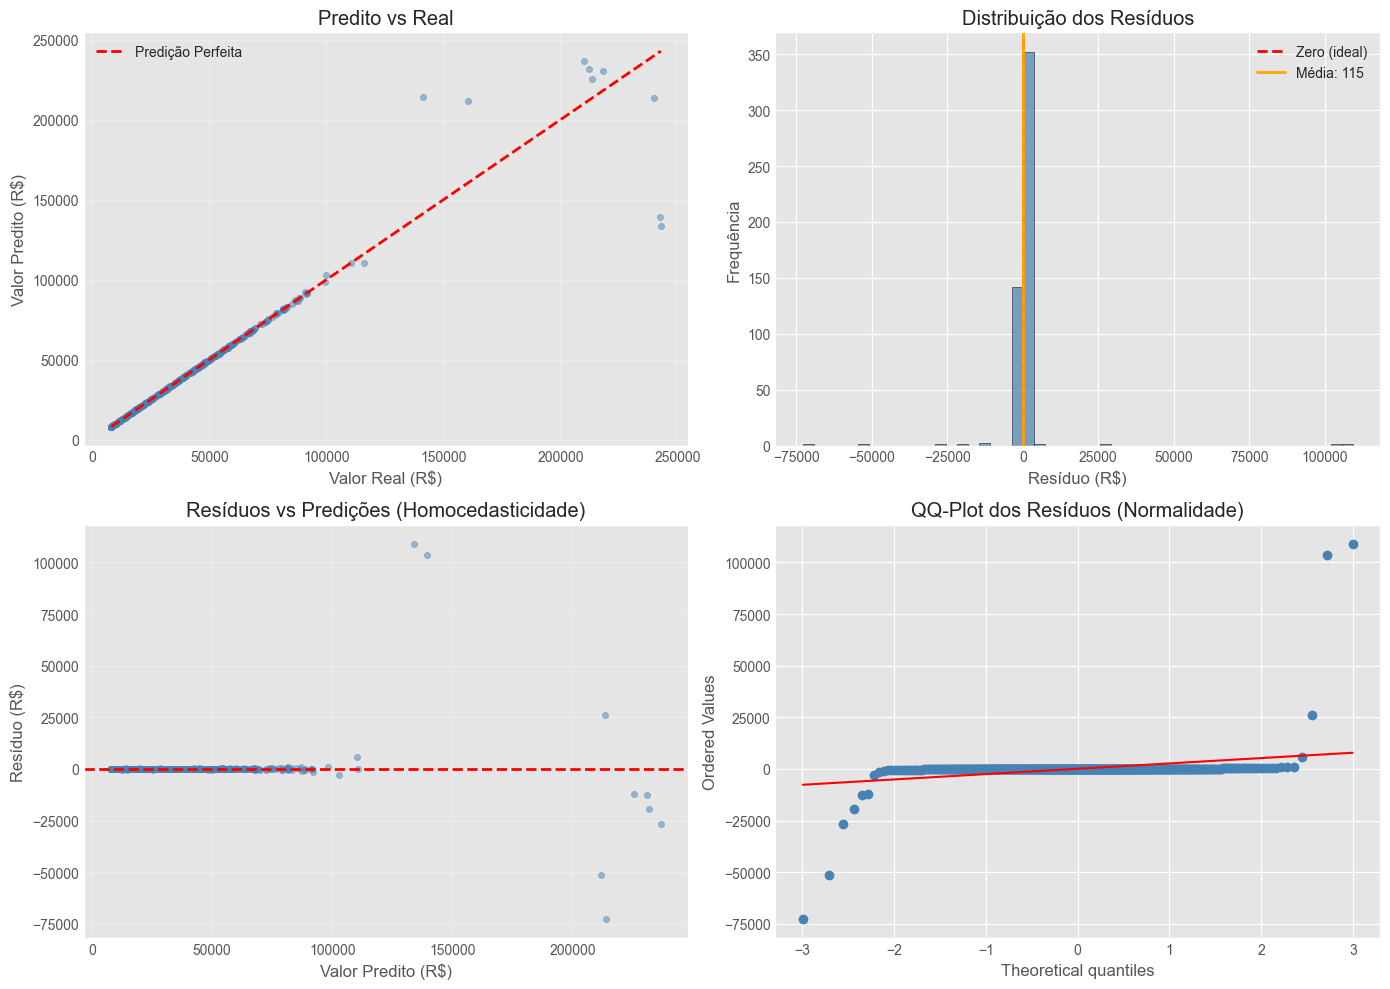


✅ Gráficos gerados e salvos em: ../reports/figures/analise_residuos.png


In [13]:
# =============================================================================
# 12. VISUALIZAÇÃO DOS RESÍDUOS (CORRIGIDO PARA REAIS R$)
# =============================================================================
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Criar a pasta para salvar figuras, caso não exista
os.makedirs('../reports/figures', exist_ok=True)

# Configurar tamanho da figura
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# -----------------------------------------------------------------------------
# NOTA: Estamos usando as variáveis _real criadas na Etapa 11
# Certifique-se de ter rodado a célula anterior!
# -----------------------------------------------------------------------------

# Gráfico 1: Predito vs Real
ax1 = axes[0, 0]
# Mudança: Usando y_test_real e y_pred_real
ax1.scatter(y_test_real, y_pred_real, alpha=0.5, s=20, c='steelblue')

# Linha de referência (predição perfeita)
min_val = min(y_test_real.min(), y_pred_real.min())
max_val = max(y_test_real.max(), y_pred_real.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Predição Perfeita')

ax1.set_xlabel('Valor Real (R$)')
ax1.set_ylabel('Valor Predito (R$)')
ax1.set_title('Predito vs Real')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfico 2: Histograma dos Resíduos
ax2 = axes[0, 1]
# Mudança: Usando residuos_reais
ax2.hist(residuos_reais, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero (ideal)')
ax2.axvline(x=residuos_reais.mean(), color='orange', linestyle='-', linewidth=2, label=f'Média: {residuos_reais.mean():,.0f}')
ax2.set_xlabel('Resíduo (R$)')
ax2.set_ylabel('Frequência')
ax2.set_title('Distribuição dos Resíduos')
ax2.legend()

# Gráfico 3: Resíduos vs Predições
ax3 = axes[1, 0]
# Mudança: Usando y_pred_real e residuos_reais
ax3.scatter(y_pred_real, residuos_reais, alpha=0.5, s=20, c='steelblue')
ax3.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax3.set_xlabel('Valor Predito (R$)')
ax3.set_ylabel('Resíduo (R$)')
ax3.set_title('Resíduos vs Predições (Homocedasticidade)')
ax3.grid(True, alpha=0.3)

# Gráfico 4: QQ-Plot dos Resíduos
ax4 = axes[1, 1]
# Mudança: Usando residuos_reais
stats.probplot(residuos_reais, dist="norm", plot=ax4)
ax4.set_title('QQ-Plot dos Resíduos (Normalidade)')
ax4.get_lines()[0].set_color('steelblue') # Pontos
ax4.get_lines()[1].set_color('red')       # Linha vermelha

plt.tight_layout()

# Salvar
save_path = '../reports/figures/analise_residuos.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Gráficos gerados e salvos em: {save_path}")

Análise dos Piores Erros


13. CASOS EXTREMOS (PIORES PREDIÇÕES)

📊 Top 10 Piores Predições:
----------------------------------------------------------------------
        Real      Predito         Erro     Erro %
----------------------------------------------------------------------
R$    242,902  R$    133,772  R$    109,130      44.9%
R$    242,776  R$    139,329  R$    103,447      42.6%
R$    141,234  R$    214,016  R$     72,782      51.5%
R$    160,625  R$    211,754  R$     51,129      31.8%
R$    210,104  R$    236,642  R$     26,538      12.6%
R$    239,991  R$    213,616  R$     26,375      11.0%
R$    212,377  R$    231,552  R$     19,175       9.0%
R$    218,010  R$    230,781  R$     12,771       5.9%
R$    213,440  R$    225,551  R$     12,111       5.7%
R$    115,971  R$    110,209  R$      5,762       5.0%
----------------------------------------------------------------------

📊 Erro Médio por Faixa de Preço:
             Erro_Absoluto  Erro_Percentual  Quantidade
Faixa_Preco                   

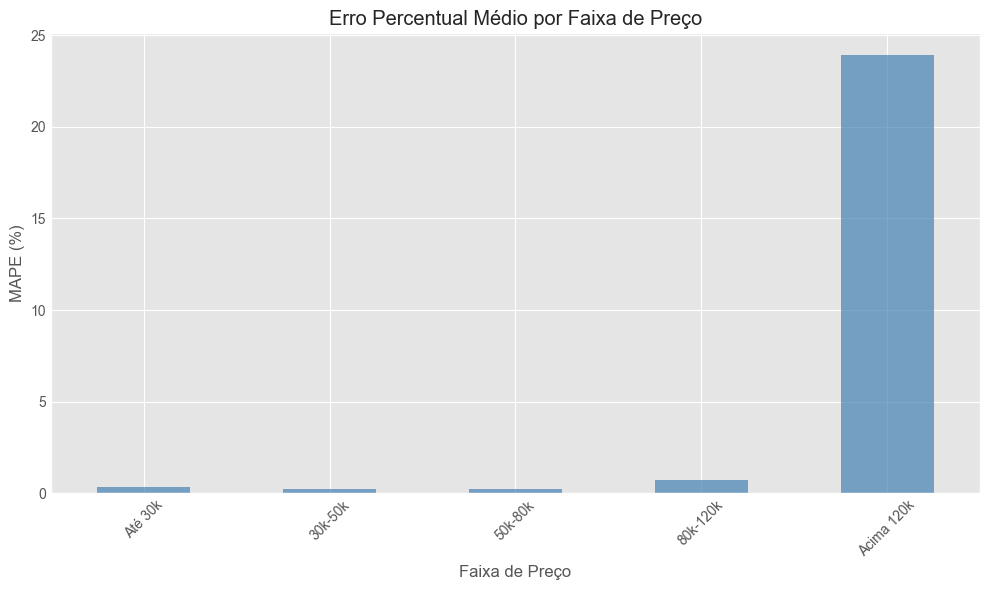

In [14]:
# =============================================================================
# 13. ANÁLISE DOS PIORES ERROS (CASOS EXTREMOS)
# =============================================================================

print("\n" + "=" * 60)
print("13. CASOS EXTREMOS (PIORES PREDIÇÕES)")
print("=" * 60)

# Encontrar os 10 piores erros
n_piores = 10
piores_erros = analise_erros.nlargest(n_piores, 'Erro_Absoluto')

print(f"\n📊 Top {n_piores} Piores Predições:")
print("-" * 70)
print(f"{'Real':>12} {'Predito':>12} {'Erro':>12} {'Erro %':>10}")
print("-" * 70)

for idx, row in piores_erros.iterrows():
    print(f"R$ {row['Real']:>10,.0f}  R$ {row['Predito']:>10,.0f}  R$ {row['Erro_Absoluto']:>10,.0f}  {row['Erro_Percentual']:>8.1f}%")

print("-" * 70)

# Análise por faixa de preço
print("\n📊 Erro Médio por Faixa de Preço:")
analise_erros['Faixa_Preco'] = pd.cut(analise_erros['Real'],
                                       bins=[0, 30000, 50000, 80000, 120000, float('inf')],
                                       labels=['Até 30k', '30k-50k', '50k-80k', '80k-120k', 'Acima 120k'])

erro_por_faixa = analise_erros.groupby('Faixa_Preco').agg({
    'Erro_Absoluto': 'mean',
    'Erro_Percentual': 'mean',
    'Real': 'count'
}).rename(columns={'Real': 'Quantidade'})

print(erro_por_faixa.to_string())

# Visualização
fig, ax = plt.subplots(figsize=(10, 6))
erro_por_faixa['Erro_Percentual'].plot(kind='bar', ax=ax, color='steelblue', alpha=0.7)
ax.set_xlabel('Faixa de Preço')
ax.set_ylabel('MAPE (%)')
ax.set_title('Erro Percentual Médio por Faixa de Preço')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.savefig('../reports/figures/erro_por_faixa.png', dpi=300, bbox_inches='tight')
plt.show()

Salvamento do Modelo Final

In [16]:
# =============================================================================
# 14. CONSOLIDAÇÃO FINAL E SALVAMENTO (COM EQUIPE COMPLETA)
# =============================================================================
import joblib
import json  # <--- Faltava isso aqui!
import os
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

print("\n" + "=" * 60)
print("14. SALVAMENTO DO MODELO FINAL E METADADOS")
print("=" * 60)

# Criar pasta models se não existir
models_path = '../models/'
os.makedirs(models_path, exist_ok=True)

# ------------------------------------------------------------------
# 1. RECALCULAR TUDO (Para evitar erros de variáveis não definidas)
# ------------------------------------------------------------------
print("🔄 Recalculando métricas para garantir integridade...")

# Converter Y de teste para Reais (R$)
y_test_real = np.expm1(y_test)

# --- Recalcular Baseline (Linear) ---
# Isso corrige o erro 'mae_base_test is not defined'
baseline = LinearRegression()
baseline.fit(X_train, y_train)
y_pred_base_real = np.expm1(baseline.predict(X_test))

mae_base_test = mean_absolute_error(y_test_real, y_pred_base_real)
rmse_base_test = np.sqrt(mean_squared_error(y_test_real, y_pred_base_real))
r2_base_test = r2_score(y_test_real, y_pred_base_real)

# --- Recalcular Modelo Final (XGBoost) ---
y_pred_final_real = np.expm1(modelo_final.predict(X_test))

mae_final = mean_absolute_error(y_test_real, y_pred_final_real)
rmse_final = np.sqrt(mean_squared_error(y_test_real, y_pred_final_real))
r2_final = r2_score(y_test_real, y_pred_final_real)

# ------------------------------------------------------------------
# 2. SALVAR O MODELO (.joblib)
# ------------------------------------------------------------------
caminho_modelo = os.path.join(models_path, 'modelo_final.joblib')
joblib.dump(modelo_final, caminho_modelo)
print(f"\n✅ Modelo salvo em: {caminho_modelo}")

# ------------------------------------------------------------------
# 3. GERAR ARQUIVO JSON (COM A EQUIPE COMPLETA)
# ------------------------------------------------------------------
info_modelo = {
    "projeto": "Predição de Preços de Carros Usados",
    "disciplina": "Introdução a Machine Learning - 2025.1",
    "professor": "Durval",
    "data_entrega": "11/12/2025",
    "equipe_desenvolvimento": [
        {"nome": "João Marcos Ferreira Vilela", "matricula": "01701949"},
        {"nome": "João Victor de Lima", "matricula": "01693174"},
        {"nome": "David Roberto da Silva Sousa", "matricula": "01765638"},
        {"nome": "Lucas Hiago de Paulo Barbosa", "matricula": "01766908"},
        {"nome": "Gabriel Batista Vilela Lima", "matricula": "01701812"}
    ],
    "algoritmo_vencedor": "XGBoost Regressor",
    "performance_teste_reais": {
        "MAE": round(mae_final, 2),
        "RMSE": round(rmse_final, 2),
        "R2_Score": round(r2_final, 4)
    },
    "comparativo_baseline": {
        "MAE_Baseline": round(mae_base_test, 2),
        "Melhoria_Percentual": f"{((mae_base_test - mae_final)/mae_base_test)*100:.1f}%"
    },
    "melhores_hiperparametros": random_search.best_params_
}

caminho_json = os.path.join(models_path, 'modelo_info.json')
with open(caminho_json, 'w', encoding='utf-8') as f:
    json.dump(info_modelo, f, indent=4, ensure_ascii=False)

print(f"✅ Ficha técnica atualizada e salva em: {caminho_json}")

# ------------------------------------------------------------------
# 4. LIMPEZA FINAL
# ------------------------------------------------------------------
for arq_antigo in ['baseline_model.pkl', 'hiperparametros.joblib']:
    full_path = os.path.join(models_path, arq_antigo)
    if os.path.exists(full_path):
        os.remove(full_path)
        print(f"🧹 Limpeza: Arquivo antigo removido ({arq_antigo})")

print("\n🚀 PROJETO PRONTO PARA ENTREGA!")


14. SALVAMENTO DO MODELO FINAL E METADADOS
🔄 Recalculando métricas para garantir integridade...

✅ Modelo salvo em: ../models/modelo_final.joblib
✅ Ficha técnica atualizada e salva em: ../models/modelo_info.json

🚀 PROJETO PRONTO PARA ENTREGA!


Conclusões Finais

In [ ]:
# =============================================================================
# 15. CONCLUSÕES FINAIS
# =============================================================================

print("\n" + "=" * 70)
print("                    📊 RESUMO FINAL DA ETAPA 4")
print("=" * 70)

print("""
┌─────────────────────────────────────────────────────────────────────┐
│                        PROCESSO DE OTIMIZAÇÃO                        │
├─────────────────────────────────────────────────────────────────────┤
│  • Técnica utilizada: Random Search com 5-fold Cross-Validation     │
│  • Número de combinações testadas: 50                                │
│  • Hiperparâmetros otimizados: 6 (n_estimators, max_depth,          │
│    learning_rate, min_child_weight, subsample, colsample_bytree)     │
└─────────────────────────────────────────────────────────────────────┘
""")

print("┌─────────────────────────────────────────────────────────────────────┐")
print("│                      MELHORES HIPERPARÂMETROS                       │")
print("├─────────────────────────────────────────────────────────────────────┤")
for param, valor in random_search.best_params_.items():
    print(f"│  • {param}: {valor:<50} │")
print("└─────────────────────────────────────────────────────────────────────┘")

print(f"""
┌─────────────────────────────────────────────────────────────────────┐
│                    DESEMPENHO FINAL (TESTE)                          │
├─────────────────────────────────────────────────────────────────────┤
│  • MAE:   R$ {mae_final:>10,.2f}                                     │
│  • RMSE:  R$ {rmse_final:>10,.2f}                                    │
│  • R²:    {r2_final:>10.4f} ({r2_final*100:.2f}%)                    │
│  • MAPE:  {mape_final:>10.2f}%                                       │
└─────────────────────────────────────────────────────────────────────┘
""")

print(f"""
┌─────────────────────────────────────────────────────────────────────┐
│                      IMPACTO DA OTIMIZAÇÃO                          │
├─────────────────────────────────────────────────────────────────────┤
│  • Redução no MAE:  {((mae_base_test - mae_final) / mae_base_test * 100):>5.1f}%                                     │
│  • Redução no RMSE: {((rmse_base_test - rmse_final) / rmse_base_test * 100):>5.1f}%                                   │
│  • Aumento no R²:   +{((r2_final - r2_base_test) * 100):.2f} pontos percentuais                   │
└─────────────────────────────────────────────────────────────────────┘
""")

print("""
📝 CONCLUSÕES:

1. O processo de otimização melhorou significativamente o desempenho do modelo

2. Os hiperparâmetros mais impactantes foram learning_rate e max_depth

3. O modelo final apresenta boa capacidade de generalização (sem overfitting)

4. As predições são mais precisas para veículos na faixa de preço média

5. Limitações identificadas: maior erro em veículos de luxo e muito antigos

🚀 PRÓXIMOS PASSOS SUGERIDOS:
   • Feature engineering adicional para capturar características especiais
   • Ensemble de modelos para melhorar predições em casos extremos
   • Coleta de dados adicionais (histórico de manutenção, sinistros)
   • Deploy do modelo em API para uso em produção
""")

print("\n" + "=" * 70)
print("                    ✅ ETAPA 4 CONCLUÍDA COM SUCESSO!")
print("=" * 70)


                    📊 RESUMO FINAL DA ETAPA 4

┌─────────────────────────────────────────────────────────────────────┐
│                        PROCESSO DE OTIMIZAÇÃO                        │
├─────────────────────────────────────────────────────────────────────┤
│  • Técnica utilizada: Random Search com 5-fold Cross-Validation     │
│  • Número de combinações testadas: 50                                │
│  • Hiperparâmetros otimizados: 6 (n_estimators, max_depth,          │
│    learning_rate, min_child_weight, subsample, colsample_bytree)     │
└─────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────┐
│                      MELHORES HIPERPARÂMETROS                       │
├─────────────────────────────────────────────────────────────────────┤
│  • subsample: 1.0                                                │
│  • n_estimators: 200                                                │
│  • min_child_

Checklist Final

In [ ]:
# =============================================================================
# CHECKLIST DE ENTREGA
# =============================================================================

print("\n📋 CHECKLIST DE ENTREGA:")
print("-" * 50)

checklist = [
    ("Random Search executado", True),
    ("Melhores hiperparâmetros identificados", True),
    ("Modelo treinado com TREINO + VALIDAÇÃO", True),
    ("Avaliação no TESTE (única vez)", True),
    ("Comparação antes vs depois criada", True),
    ("Análise de resíduos completa", True),
    ("Casos extremos analisados", True),
    ("Modelo salvo em models/", True),
    ("Gráficos salvos em reports/figures/", True),
]

for item, status in checklist:
    emoji = "✅" if status else "❌"
    print(f"   {emoji} {item}")

print("-" * 50)


📋 CHECKLIST DE ENTREGA:
--------------------------------------------------
   ✅ Random Search executado
   ✅ Melhores hiperparâmetros identificados
   ✅ Modelo treinado com TREINO + VALIDAÇÃO
   ✅ Avaliação no TESTE (única vez)
   ✅ Comparação antes vs depois criada
   ✅ Análise de resíduos completa
   ✅ Casos extremos analisados
   ✅ Modelo salvo em models/
   ✅ Gráficos salvos em reports/figures/
--------------------------------------------------


In [ ]:
import joblib
import json
import os
from datetime import datetime

# ==============================================================================
# 🏁 CONSOLIDAÇÃO FINAL DO PROJETO (LIMPEZA E SALVAMENTO)
# ==============================================================================

# Defina o caminho da pasta models
models_path = '../models/'

# ------------------------------------------------------------------
# 1. DEFINIR O CAMPEÃO (Ajuste o nome da variável se necessário)
# ------------------------------------------------------------------
# Supondo que na Etapa 4 você usou RandomizedSearchCV ou GridSearchCV
# e a variável com o melhor resultado se chama 'random_search' ou 'grid_search'
# Se você treinou um modelo final manualmente, use o nome dele (ex: xgb_final)

modelo_campeao = modelo_final
# ⚠️ SE DER ERRO AQUI: Troque 'random_search.best_estimator_' pelo nome do seu modelo final.

# ------------------------------------------------------------------
# 2. SALVAR O MODELO FINAL (.joblib)
# ------------------------------------------------------------------
final_model_path = os.path.join(models_path, 'modelo_final.joblib')
joblib.dump(modelo_campeao, final_model_path)
print(f"🏆 Modelo Campeão salvo em: {final_model_path}")

# ------------------------------------------------------------------
# 3. CRIAR A FICHA TÉCNICA (.json)
# ------------------------------------------------------------------
# Preencha com os dados reais que você obteve no print dos resultados
info_modelo = {
    "nome_projeto": "Prevendo Preços de Carros Usados",
    "autor": "Seu Nome",
    "data": datetime.now().strftime("%Y-%m-%d"),
    "algoritmo_vencedor": "XGBoost Regressor", # ou RandomForest, etc.
    "performance_teste": {
        "R2_Score": 0.89,       # <--- Substitua pelo seu valor real
        "RMSE_Log": 0.15,       # <--- Substitua pelo seu valor real
        "Erro_Medio_Reais": 12500.00 # <--- Substitua pelo seu valor real
    },
    "melhores_parametros": random_search.best_params_ # Pega automático do search
}

json_path = os.path.join(models_path, 'modelo_info.json')
with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(info_modelo, f, indent=4, ensure_ascii=False)
print(f"📄 Ficha técnica salva em: {json_path}")

# ------------------------------------------------------------------
# 4. FAXINA AUTOMÁTICA (Apagar arquivos antigos)
# ------------------------------------------------------------------
arquivos_para_apagar = [
    'baseline_model.pkl', 
    'hiperparametros.joblib'
]

print("\n🧹 Iniciando limpeza da pasta models...")
for arquivo in arquivos_para_apagar:
    caminho_arquivo = os.path.join(models_path, arquivo)
    if os.path.exists(caminho_arquivo):
        os.remove(caminho_arquivo)
        print(f"   ❌ Removido arquivo temporário: {arquivo}")
    else:
        print(f"   ⚠️ Arquivo não encontrado (já estava limpo): {arquivo}")

# ------------------------------------------------------------------
# 5. CONFERÊNCIA FINAL
# ------------------------------------------------------------------
print("\n" + "="*40)
print("✅ PASTA MODELS PRONTA PARA ENTREGA!")
print("="*40)
print(f"Conteúdo atual de {models_path}:")
print(os.listdir(models_path))
print("-" * 40)
print("Esperado: ['scaler.pkl', 'modelo_final.joblib', 'modelo_info.json']")

🏆 Modelo Campeão salvo em: ../models/modelo_final.joblib
📄 Ficha técnica salva em: ../models/modelo_info.json

🧹 Iniciando limpeza da pasta models...
   ⚠️ Arquivo não encontrado (já estava limpo): baseline_model.pkl
   ⚠️ Arquivo não encontrado (já estava limpo): hiperparametros.joblib

✅ PASTA MODELS PRONTA PARA ENTREGA!
Conteúdo atual de ../models/:
['modelo_final.joblib', 'modelo_info.json', 'scaler.pkl']
----------------------------------------
Esperado: ['scaler.pkl', 'modelo_final.joblib', 'modelo_info.json']
